# TODO:

#### Splits
- Enable list of splits:


#### SeaTurtles



In [2]:
import pandas as pd
import numpy as np

import os
import sys
sys.path.append('..')

from wildlife_training.dataset_tools import ImageDataset, CategoryImageDataset
from wildlife_training.dataset_tools import split_standard, split_expanding_years
from wildlife_datasets import datasets
dataset_factory = datasets.SeaTurtleID('/mnt/data/turtles/datasets/datasets/SeaTurtleID')

# Cleanup data
dataset_factory.df = dataset_factory.df[~dataset_factory.df['bbox'].isnull()]
dataset_factory.df = dataset_factory.df[dataset_factory.df.groupby('identity')['id'].transform('count') > 1]
dataset_factory.df = dataset_factory.df.reset_index(drop=True)
dataset_factory.df['year'] = dataset_factory.df['date'].str[:4].values


In [3]:
import torch
import torch.nn as nn
from timm import create_model
from timm.data.transforms_factory import create_transform
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score


In [4]:
# Prepare transforms
transform_valid = create_transform(
        input_size = 224,
        is_training = False,
    )

transform_train = create_transform(
        input_size = 224,
        is_training = True,
    )

# Prepare splits
splitter = StratifiedShuffleSplit(
    n_splits=2,
    random_state=1,
    test_size=0.5
)

datasets = split_standard(
    df = dataset_factory.df,
    root = dataset_factory.root,
    splitter = splitter,
    create_dataset = ImageDataset,
    transform_train = transform_train,
    transform_valid = transform_valid,
    img_load='bbox',
)


/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [13]:
import numpy as np
from wildlife_training.utils import prepare_batch
from wildlife_training.utils import grid_plot
from torch.utils.data import DataLoader

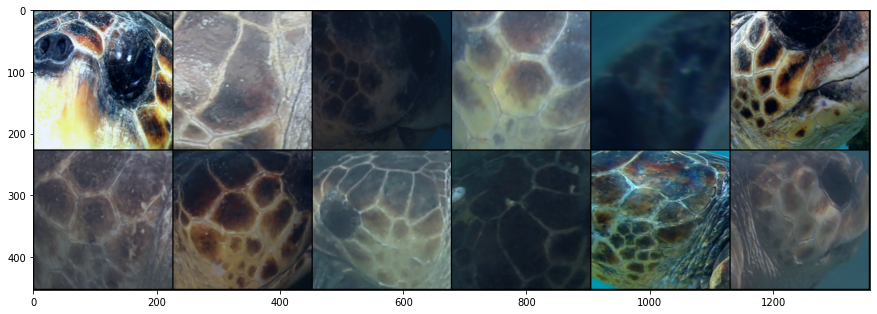

In [16]:
loader = DataLoader(datasets[0]['train'], shuffle=False, batch_size=12)
x1, y = next(iter(loader))


grid_plot(x1, nrows=6, figsize=(15, 15))

In [16]:
from timm.data.transforms_factory import create_transform

transform_valid = create_transform(
        input_size = 224,
        is_training = False,
    )

transform_train = create_transform(
        input_size = 224,
        is_training = True,
        auto_augment = 'rand-m10-n2-mstd1',
    )

In [16]:
from runpy import run_path
payload = run_path('/home/cermavo3/projects/datasets/experiments/test/configs/cls_baseline.py')['payload']

/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [43]:


dataset = CategoryImageDataset(
    dataset_factory.df,
    dataset_factory.root,
    category='position',
    img_load='segmentation',
    transform=transform_train)

loader = DataLoader(dataset, shuffle=False, batch_size=12)
(x1, x2), y = next(iter(loader))


grid_plot(x1, nrows=6, figsize=(15, 15))

In [85]:
datasets = split_expanding_years(
    dataset_factory.df,
    dataset_factory.root,
    create_dataset = ImageDataset,
    transform_train = transform_train,
    transform_valid = transform_valid,
    img_load='bbox',
)


datasets = split_basic(
    dataset_factory.df,
    dataset_factory.root,
    splitter = StratifiedShuffleSplit(n_splits = 1, random_state=1, test_size=0.5),
    create_dataset = ImageDataset,
    transform_train = transform_train,
    transform_valid = transform_valid,
    img_load='bbox',
)

In [92]:
loader = DataLoader(splits[0]['train'], shuffle=False, batch_size=12)
x1, y = next(iter(loader))

/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


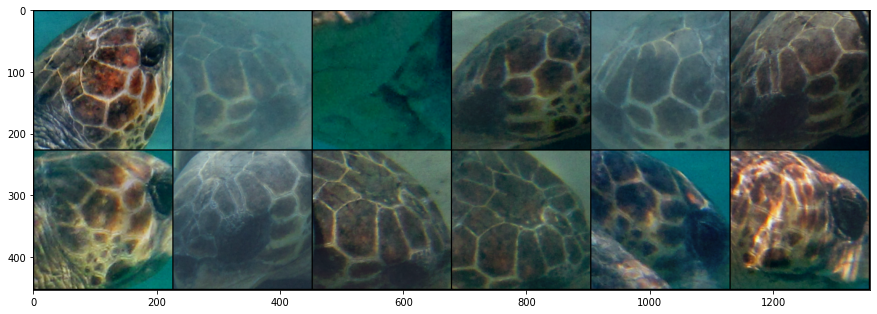

In [91]:
grid_plot(x1, nrows=6, figsize=(15, 15))

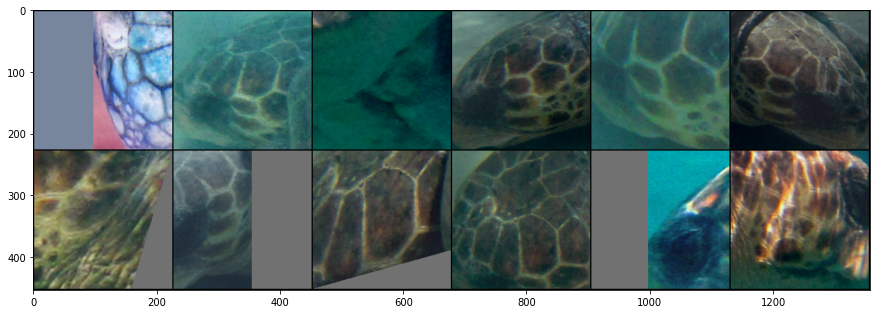

In [93]:
grid_plot(x1, nrows=6, figsize=(15, 15))

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit


In [92]:
create_transform(
    input_size = 224,
    is_training = False,
    )

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

## Simple classification config

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from timm import create_model
from timm.data.transforms_factory import create_transform
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import os
import sys
sys.path.append('..')

# Wildlife training
from trainers import BasicTrainer
from dataset_tools import BasicDataset
from inference import Evaluation

# Wildlife dataset
from wildlife_datasets import utils

config = {
    'batch_size': 64,
    'device': 'cuda',
    'epochs': 50,
    'workers': 8,
    'folder': 'runs/',
}


info_datasets = utils.info_datasets_full
info_datasets = utils.unique_datasets_list(info_datasets)
root_dataset = '/mnt/data/turtles/datasets/datasets'
root_dataframe = '/mnt/data/turtles/datasets/dataframes'
dataset_factory = utils.loader.load_dataset(info_datasets[-4], root_dataset, root_dataframe)
dataset_factory.df = dataset_factory.df[~dataset_factory.df['bbox'].isnull()]
one_per_class = dataset_factory.df.groupby('identity')['identity'].transform('count') > 1
print(f"{sum(~one_per_class)=}")
dataset_factory.df = dataset_factory.df[one_per_class] # Only 1 observation
dataset_factory.df = dataset_factory.df.reset_index()


# Create datasets
train_df, valid_df = dataset_factory.split_data(
    splitter = StratifiedShuffleSplit(
        n_splits = 1,
        random_state = 1,
        test_size = 0.3),
)

dataset_train = BasicDataset(
    train_df,
    dataset_factory.root,
    img_load = 'bbox',
    transform = create_transform(
        input_size = 224,
        is_training = True,
        auto_augment = 'rand-m10-n2-mstd1',
    )
)

dataset_valid = BasicDataset(
    df = valid_df,
    root = dataset_factory.root,
    img_load = 'bbox',
    transform = create_transform(
        input_size = 224,
        is_training = False,
    )
)


# Setup backbone
model = create_model(
    model_name = 'efficientnet_b0',
    pretrained = True,
    num_classes = len(dataset_train.label_map),
)

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Evaluation metrics
evaluation = Evaluation(
    method = 'classifier',
    metrics = {
        'acc': accuracy_score,
        'balanced_acc': balanced_accuracy_score,
    },
    device = config['device']
)

# Trainer
trainer = BasicTrainer(
    model = model,
    evaluation = evaluation,
    optimizer = optimizer,
    device = config['device'],
)

payload = {
    'config': config,
    'trainer': trainer,
    'datasets': {
        'train': dataset_train,
        'valid': dataset_valid,
    },
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sum(~one_per_class)=1


/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader

# Training
epochs = payload['config']['epochs']
trainer = payload['trainer']
loader = DataLoader(
    dataset = payload['datasets']['train'],
    batch_size = payload['config']['batch_size'],
    num_workers=config['workers'],
    shuffle=True,
    )

for e in range(trainer.current_epoch + 1, epochs):
    print(f'======= Epoch {e} =======')
    print('train')
    trainer.train_epoch(loader, e)

    # Evaluate metrics
    print('eval')
    metrics = trainer.evaluate(payload['datasets'])
    print(metrics)

## Config embbeddings

In [12]:
import torch
import torch.nn as nn
from timm import create_model
from timm.data.transforms_factory import create_transform
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import os
import sys
root = os.path.join(os.path.dirname(os.path.abspath('')), '..')
sys.path.append(root)
sys.path.append('..') #TODO: remove
from pytorch_metric_learning import losses


# Wildlife training
from wildlife_training.trainers import EmbeddingTrainer
from wildlife_training.dataset_tools import BasicDataset
from wildlife_training.inference import Evaluation

# Wildlife dataset
from wildlife_datasets import utils

config = {
    'batch_size': 64,
    'device': 'cpu',
    'epochs': 50,
    'workers': 0,
    'folder': 'runs/',
    'embedding_size': 512,
    #'name': os.path.splitext(os.path.basename(__file__))[0],
}

# Load dataset factory
info_datasets = utils.info_datasets_full
info_datasets = utils.unique_datasets_list(info_datasets)
root_dataset = '/mnt/data/turtles/datasets/datasets'
root_dataframe = '/mnt/data/turtles/datasets/dataframes'
dataset_factory = utils.loader.load_dataset(info_datasets[-4], root_dataset, root_dataframe)
dataset_factory.df = dataset_factory.df[~dataset_factory.df['bbox'].isnull()]
one_per_class = dataset_factory.df.groupby('identity')['identity'].transform('count') > 1
print(f"{sum(~one_per_class)=}")
dataset_factory.df = dataset_factory.df[one_per_class] # Only 1 observation
dataset_factory.df = dataset_factory.df.reset_index()


# Create datasets
train_df, valid_df = dataset_factory.split_data(
    splitter = StratifiedShuffleSplit(
        n_splits = 1,
        random_state = 1,
        test_size = 0.3),
)


dataset_train = BasicDataset(
    train_df,
    dataset_factory.root,
    img_load = 'bbox',
    transform = create_transform(
        input_size = 224,
        is_training = True,
        auto_augment = 'rand-m10-n2-mstd1',
    )
)

dataset_reference = BasicDataset(
    df = train_df,
    root = dataset_factory.root,
    img_load = 'bbox',
    transform = create_transform(
        input_size = 224,
        is_training = False,
    )
)

dataset_valid = BasicDataset(
    df = valid_df,
    root = dataset_factory.root,
    img_load = 'bbox',
    transform = create_transform(
        input_size = 224,
        is_training = False,
    )
)

# Setup backbone
model = create_model(
    model_name = 'efficientnet_b0',
    pretrained = True,
    num_classes = config['embedding_size'],
    )

# Setup loss
loss_func = losses.ArcFaceLoss(
    num_classes = len(dataset_train.label_map),
    embedding_size = config['embedding_size'],
    margin = 28.6,
    scale = 64,
    )

# Optimizers
optimizers = {
    'embedder': torch.optim.Adam(model.parameters(), lr=1e-3),
    'loss': torch.optim.Adam(loss_func.parameters(), lr=1e-3),
}

evaluation = Evaluation(
    method = 'knn',
    k = 1,
    metrics = {
        'acc': accuracy_score,
        'balanced_acc': balanced_accuracy_score,
    },
    device = config['device']
)

trainer = EmbeddingTrainer(
    embedder = model,
    loss_func = loss_func,
    optimizers = optimizers,
    evaluation = evaluation,
    device = config['device'],
)

payload = {
    'config': config,
    'trainer': trainer,
    'datasets': {
        'train': dataset_train,
        'reference': dataset_reference,
        'query': dataset_valid
    },
}


sum(~one_per_class)=1


/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [13]:
from torch.utils.data import DataLoader

# Training
epochs = payload['config']['epochs']
trainer = payload['trainer']
loader = DataLoader(
    dataset = payload['datasets']['train'],
    batch_size = payload['config']['batch_size'],
    num_workers=config['workers'],
    shuffle=True,
    )

for e in range(trainer.current_epoch + 1, epochs):
    print(f'======= Epoch {e} =======')
    print('train')
    trainer.train_epoch(loader, e)

    # Evaluate metrics
    print('eval')
    metrics = trainer.evaluate(payload['datasets'])
    print(metrics)

======= Epoch 1 =======
train


Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 1: 100%|██████████| 9/9 [01:15<00:00,  8.38s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


{'acc': 0.8218623481781376, 'balanced_acc': 0.7855114638447971}
======= Epoch 2 =======
train


Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 2: 100%|██████████| 9/9 [01:17<00:00,  8.59s/it]


eval


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


{'acc': 0.8259109311740891, 'balanced_acc': 0.7892760942760944}
======= Epoch 3 =======
train


Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 3: 100%|██████████| 9/9 [01:14<00:00,  8.30s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


{'acc': 0.8421052631578947, 'balanced_acc': 0.8006509539842873}
======= Epoch 4 =======
train


Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 4: 100%|██████████| 9/9 [01:18<00:00,  8.69s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


{'acc': 0.8906882591093117, 'balanced_acc': 0.8681200897867565}
======= Epoch 5 =======
train


Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 5: 100%|██████████| 9/9 [01:16<00:00,  8.51s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


{'acc': 0.902834008097166, 'balanced_acc': 0.8829180695847362}
======= Epoch 6 =======
train


Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 6: 100%|██████████| 9/9 [01:15<00:00,  8.43s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


{'acc': 0.8825910931174089, 'balanced_acc': 0.8315432098765434}
======= Epoch 7 =======
train


Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 7: 100%|██████████| 9/9 [01:16<00:00,  8.55s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


{'acc': 0.9190283400809717, 'balanced_acc': 0.8836419753086419}
======= Epoch 8 =======
train


Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 8: 100%|██████████| 9/9 [01:13<00:00,  8.20s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


{'acc': 0.9311740890688259, 'balanced_acc': 0.8889506172839506}
======= Epoch 9 =======
train


Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 9: 100%|██████████| 9/9 [01:14<00:00,  8.31s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


{'acc': 0.9190283400809717, 'balanced_acc': 0.8784567901234567}
======= Epoch 10 =======
train


Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 10: 100%|██████████| 9/9 [01:15<00:00,  8.40s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


{'acc': 0.9068825910931174, 'balanced_acc': 0.8750176366843032}
======= Epoch 11 =======
train


Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 11: 100%|██████████| 9/9 [01:14<00:00,  8.33s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


{'acc': 0.9271255060728745, 'balanced_acc': 0.9105731922398589}
======= Epoch 12 =======
train


Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 12: 100%|██████████| 9/9 [01:16<00:00,  8.47s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


{'acc': 0.9433198380566802, 'balanced_acc': 0.9129012345679013}
======= Epoch 13 =======
train


Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 13: 100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


{'acc': 0.9311740890688259, 'balanced_acc': 0.895679012345679}
======= Epoch 14 =======
train


Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 14: 100%|██████████| 9/9 [01:17<00:00,  8.59s/it]


eval


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


{'acc': 0.9392712550607287, 'balanced_acc': 0.9101234567901234}
======= Epoch 15 =======
train


Epoch 15:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 15: 100%|██████████| 9/9 [01:16<00:00,  8.46s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


{'acc': 0.9392712550607287, 'balanced_acc': 0.9025925925925926}
======= Epoch 16 =======
train


Epoch 16:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 16: 100%|██████████| 9/9 [01:19<00:00,  8.84s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


{'acc': 0.9392712550607287, 'balanced_acc': 0.9011111111111112}
======= Epoch 17 =======
train


Epoch 17:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 17: 100%|██████████| 9/9 [01:14<00:00,  8.27s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


{'acc': 0.9392712550607287, 'balanced_acc': 0.8985185185185186}
======= Epoch 18 =======
train


Epoch 18:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 18: 100%|██████████| 9/9 [01:17<00:00,  8.57s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


{'acc': 0.9473684210526315, 'balanced_acc': 0.9034567901234568}
======= Epoch 19 =======
train


Epoch 19:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 19: 100%|██████████| 9/9 [01:12<00:00,  8.03s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


{'acc': 0.951417004048583, 'balanced_acc': 0.9340740740740742}
======= Epoch 20 =======
train


Epoch 20:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 20: 100%|██████████| 9/9 [01:15<00:00,  8.39s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


{'acc': 0.9635627530364372, 'balanced_acc': 0.9479012345679013}
======= Epoch 21 =======
train


Epoch 21:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 21: 100%|██████████| 9/9 [01:12<00:00,  8.04s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


{'acc': 0.9595141700404858, 'balanced_acc': 0.9424074074074074}
======= Epoch 22 =======
train


Epoch 22:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 22: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]


eval


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


{'acc': 0.9635627530364372, 'balanced_acc': 0.9458641975308643}
======= Epoch 23 =======
train


Epoch 23:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 23: 100%|██████████| 9/9 [01:11<00:00,  7.89s/it]


eval


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


{'acc': 0.97165991902834, 'balanced_acc': 0.948888888888889}
======= Epoch 24 =======
train


Epoch 24:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Epoch 24:  33%|███▎      | 3/9 [00:42<01:24, 14.16s/it]


KeyboardInterrupt: 

In [16]:

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_metric_learning.utils.inference import FaissKNN
from pytorch_metric_learning import testers


In [17]:
def remap_labels(label_train, label_valid):
    '''
    Map two potentially disjoint label sets to the same integer labels.
    
    Example: 
        remap_labels(['x', 'y', 'z'], ['x', 'x', 'w'])
        >>> (array([1, 3, 2]), array([1, 1, 0]), array(['w', 'x', 'z', 'y'], dtype=object))

    '''
    label, label_all_map = pd.factorize(list(set.union(set(label_train), set(label_valid))))
    label_all_dict = {value: i for i, value in enumerate(label_all_map)}

    label_train = list(map(lambda x: label_all_dict[x], label_train))
    label_valid = list(map(lambda x: label_all_dict[x], label_valid))
    return np.array(label_train), np.array(label_valid), np.array(label_all_map)


def predict_knn(embedder, dataset_train, dataset_valid, k=5, **kwargs):
    '''
    Calculates top K predictions using embedder and nearest neighbours in train dataset.

    Example:
        predicted, _ = predict_knn(embedder, dataset_train, dataset_valid)
        actual = dataset_valid.label_map[dataset_valid.label]
        calculate_accuracy(actual, predicted)
    '''
    # Embeddings
    embedder = embedder.eval()
    tester = testers.BaseTester(data_and_label_getter=lambda x: (x['image'], x['label']))
    embeddings_train, _ = tester.get_all_embeddings(dataset_train, embedder)
    embeddings_valid, _ = tester.get_all_embeddings(dataset_valid, embedder)

    # Labels
    if len(dataset_valid.label_map) == 0: # If there are no labels in valid.
        label_name_valid = []
    else:
        label_name_valid = dataset_valid.label_map[dataset_valid.label]
    label_name_train = dataset_train.label_map[dataset_train.label]
    label_train, label_valid, label_map = remap_labels(label_name_train, label_name_valid)

    # Predictions
    knn_function = FaissKNN()
    score, index = knn_function(embeddings_valid, k, embeddings_train)
    predicted = label_map[label_train[index.cpu()]]
    return predicted, score


In [116]:
dataset_train = payload['datasets']['reference']
dataset_valid = payload['datasets']['query']
embedder = model
k = 1

embedder = embedder.eval()
tester = testers.BaseTester(data_and_label_getter=lambda x: (x['image'], x['label']))
embeddings_train, _ = tester.get_all_embeddings(dataset_train, embedder)
embeddings_valid, _ = tester.get_all_embeddings(dataset_valid, embedder)

# Labels
if len(dataset_valid.label_map) == 0: # If there are no labels in valid.
    label_name_valid = []
else:
    label_name_valid = dataset_valid.label_map[dataset_valid.label]
label_name_train = dataset_train.label_map[dataset_train.label]
label_train, label_valid, label_map = remap_labels(label_name_train, label_name_valid)

# Predictions
knn_function = FaissKNN()
score, index = knn_function(embeddings_valid, k, embeddings_train)
predicted = label_map[label_train[index.cpu()]]

100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


TypeError: 'FaissKNN' object is not callable

In [ ]:
from pytorch_metric_learning.utils.inference import FaissKNN

In [168]:
predict_knn(embedder,
    dataset_train,
    dataset_valid)
actual = dataset_valid.label_map[dataset_valid.label]
balanced_accuracy_score(actual, predicted)

100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


0.9459259259259258

In [114]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f40efcc5990> >

In [65]:
torch.equal(F.normalize(embeddings_train2))

tensor(True)

In [81]:
balanced_accuracy_score(actual, predicted)

0.9459259259259258

In [ ]:
# Predictions
knn_function = FaissKNN()
score, index = knn_function(embeddings_valid, k, embeddings_train)
predicted = label_map[label_train[index.cpu()]]

In [18]:
predicted, score = predict_knn(model, payload['datasets']['reference'],  payload['datasets']['query'], k=1)
actual = dataset_valid.label_map[dataset_valid.label]

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


In [21]:
balanced_accuracy_score(actual, predicted)

0.9459259259259258

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class Embedder(nn.Module):
    def __init__(self, trainer):
        super().__init__()
        self.model = trainer.model

    def forward(self, x):
        out = F.relu(self.model.bn1(model.conv1(x)))
        out = self.model.layer1(out)
        out = self.model.layer2(out)
        out = self.model.layer3(out)
        out = self.model.layer4(out)
        out = F.avg_pool2d(out, 4)
        return out.mean(dim=(2, 3))


sys.path.append('/home/cermavo3/projects/adv-ml/')
from core.models import create_model
from core.utils import trainers


config = {
    'batch_size': 256,
    'device': 'cpu',
    'epochs': 120,
}


model = timm.create_model(
    model_name = 'efficientnet_b0',
    pretrained = True,
    num_classes = 0,
    )

model = create_model('resnet18')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90, 100], gamma=0.1)

trainer = trainers.AdversarialTraining(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    attack = None,
    device = config['device'],
)

#embedder = Embedder(trainer)
#path = '/home/cermavo3/projects/adv-ml/experiments/cifar_basic/runs/at/Aug11_07-27-33-8134_at/model_latest.pth'
#trainer.load_checkpoint(path)

In [4]:
model = timm.create_model(
    model_name = 'efficientnet_b0',
    pretrained = True,
    num_classes = 0,
    )

In [5]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
evaluation = Evaluation(
    method = 'knn',
    metrics = {
        'acc': accuracy_score,
        'balanced_acc': balanced_accuracy_score,
    }
)

In [6]:
metrics = evaluation(model, dataset_reference, dataset_valid)

100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


In [7]:
metrics

{'acc': 0.8218623481781376, 'balanced_acc': 0.7867620650953984}

In [90]:
metrics

{'acc': 0.6275303643724697, 'balanced_acc': 0.5797202180535515}

In [ ]:
pred = predict_knn(embedder, dataset_reference, dataset_valid, k=1)
predicted, score = pred

In [66]:
predicted, score = pred
sum(dataset_valid.df['identity'] == predicted[:, 0]) / len(dataset_valid.df)

0.6275303643724697

In [76]:
actual = dataset_valid.label_map[dataset_valid.label]
balanced_accuracy_score(actual, predicted)

0.5797202180535515

In [77]:
accuracy_score(actual, predicted)

0.6275303643724697